In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

## Functions to compute closest PSD

In [4]:
from statsmodels.stats.correlation_tools import cov_nearest

In [77]:
cov_nearest(A)

array([[1., 1.],
       [1., 1.]])

In [12]:
# or there is this straightforward solution
import numpy as np

def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

def is_pos_semidef(x):
    return np.all(np.linalg.eigvals(x) >= 0)

## Functions for SGD optimizer (non used)

In [ ]:
# we can develop our own optimiser (like what i did during the master thesis)
# in the general case its almost impossible to project into the space of positive definite solution
# but in the case of the parameters being the matrix, we can easily project? Do we really use this case?

# because the logic so far is we train a NN with potentially a hundred parameters but we indeed output the upper half matrix of xVx
# also we would like to use this for the unsupervised 

# check on google if there is a way to get the nearest positive definite matrix from an existing matrix?
# this also depends on the norm we choose for the projection
# https://math.stackexchange.com/questions/2776803/matrix-projection-onto-positive-semi-definite-cone-with-respect-to-the-spectral
# https://stat.ethz.ch/R-manual/R-devel/library/Matrix/html/nearPD.html
# https://stackoverflow.com/questions/10939213/how-can-i-calculate-the-nearest-positive-semi-definite-matrix
# https://www.statsmodels.org/dev/generated/statsmodels.stats.correlation_tools.cov_nearest.html

In [48]:
from torch import Tensor
from torch.optim import Optimizer
from torch.optim.optimizer import required
from typing import List, Optional

class SGD(Optimizer): 
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False, foreach: Optional[bool] = None):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            has_sparse_grad = False

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)
                    if p.grad.is_sparse:
                        has_sparse_grad = True

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgd(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=group['weight_decay'],
                momentum=group['momentum'],
                lr=group['lr'],
                dampening=group['dampening'],
                nesterov=group['nesterov'],
                maximize=group['maximize'],
                has_sparse_grad=has_sparse_grad,
                foreach=group['foreach'])

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss



def sgd(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
        # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
        has_sparse_grad: bool = None,
        foreach: bool = None,
        *,
        weight_decay: float,
        momentum: float,
        lr: float,
        dampening: float,
        nesterov: bool,
        maximize: bool):
    """Functional API that performs SGD algorithm computation.

    See :class:`~torch.optim.SGD` for details.
    """

    for i, param in enumerate(params):

        d_p = d_p_list[i]
        if weight_decay != 0:
            d_p = d_p.add(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        alpha = lr if maximize else -lr
        param.add_(d_p, alpha=alpha)

## Test with Neural Net

In [53]:
# an alternative is also to just make the change when evaluating the value function?
def _matrixEvaluated(self, x):
    ''' The output of the network is the symetric matrix P.
    '''        
    
    dim = x.shape[1]

    # the below is SUPER fast
    stackedMatrices = torch.zeros((x.shape[0], dim, dim)).to(self.device)
    outputModel = self.model(x)

    inds = np.triu_indices( dim )
    k = 0
    for i, j in zip( inds[0], inds[1] ):
        stackedMatrices[:, i, j] = outputModel[:, k]
        stackedMatrices[:, j, i] = outputModel[:, k]
        k += 1

    valueFunction = 0.5 * torch.einsum('ni, nij, nj -> n', x, stackedMatrices, x).reshape(-1, 1).to(self.device)

    return valueFunction 

In [ ]:
def get_near_psd_torch(A):
    C = (A + A.T)/2
    eigval, eigvec = torch.linalg.eigh(C)
    eigval[eigval < 0] = 0

    return eigvec @ torch.diag(eigval) @ eigvec.T

In [54]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)

In [58]:
dim = xData.shape[1]
stackedMatrices = torch.zeros((xData.shape[0], dim, dim))

In [61]:
outputModel = network.model(xData)

In [78]:
inds = np.triu_indices( dim )
k = 0
for i, j in zip( inds[0], inds[1] ):
    stackedMatrices[:, i, j] = outputModel[:, k]
    stackedMatrices[:, j, i] = outputModel[:, k]
    k += 1

In [122]:
stackedMatricesPsd = torch.zeros_like( stackedMatrices )

In [124]:
for i, mat in enumerate(stackedMatrices):
    stackedMatricesPsd[i] = get_near_psd_torch(mat)

In [2]:
layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=True, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0., 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

pointCount = 100
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-1, 1e-2]
iterations = [1000, 2000]

In [3]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)
yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
    # optimizer = SGD(params=network.model.parameters(), lr=lr)

        
    for epoch in range(iteration):
        xInt = generateData.samplePoints(pointCount)
        
        # residual
        gradInt = network.computeValueFunctionDerivative(xInt, psd=True)
        #equation = lqr.computeHamiltonJacobiEquation(xInt, gradInt)
        #loss = torch.mean( equation**2 )

        # data
        yData = network.computeValueFunction(xData)
        loss = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2]], which is output 0 of LinalgEighBackward, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

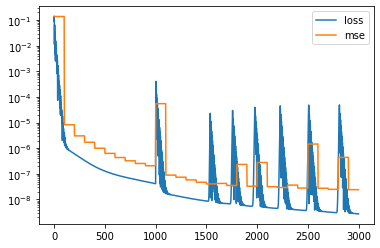

In [129]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

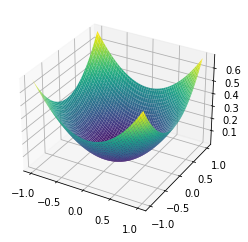

In [130]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');